**Comparaision VITS/Langevin**

Data : 

Return 
- X, of dimention, n_samples, n_features
- Y of dimention n_targets  * n_samples
- theta star is true_weights



A fiare varier pour notre problème : 

- 1) Imporn_features with n_informative features pour l'exploration à montrer
- 2) effective_rank : (int)  The approximate number of singular vectors required to explain most of the input data by linear combinations. 





bias =0

A faire varier : n_informative pour le coté exploration

In [446]:
from sklearn.datasets._samples_generator import check_array, check_random_state, make_low_rank_matrix
import numpy as np
from sklearn.utils import shuffle as util_shuffle

In [447]:
def regression_model(
    n_samples=100,
    n_features=100,
    n_informative=10,
    n_targets=1,
    bias=0.0,
    effective_rank=None,
    tail_strength=0.9,
    noise=1,
    shuffle=True,
    coef=True,
    random_state=None,
):
    
    n_informative = min(n_features, n_informative)
    generator = check_random_state(random_state)

    if effective_rank is None:
        # Randomly generate a well conditioned input set
        X = generator.standard_normal(size=(n_samples, n_features))
    else:
        # Randomly generate a low rank, fat tail input set
        X = make_low_rank_matrix(
            n_samples=n_samples,
            n_features=n_features,
            effective_rank=effective_rank,
            tail_strength=tail_strength,
            random_state=generator,
        )

    
    #n_samples=100
    #gauss_matrix= np.random.normal(size=(20,n_features))
   # X=gauss_matrix[np.random.randint(gauss_matrix.shape[0], size=n_samples), : ]

    print("cond",np.linalg.cond(X.T@X))
                    
    ground_truth = np.zeros((n_features, n_targets))
    ground_truth[:n_informative, :] = 100 * generator.uniform(
        size=(n_informative, n_targets)
    )

    y = np.dot(X, ground_truth) + bias

    # Add noise
    if noise > 0.0:
        y += generator.normal(scale=noise, size=y.shape)

    # Randomly permute samples and features
    if shuffle:
        X, y = util_shuffle(X, y, random_state=generator)

        indices = np.arange(n_features)
        generator.shuffle(indices)
        X[:, :] = X[:, indices]
        ground_truth = ground_truth[indices]

    y = np.squeeze(y)

    if coef:
        return X, y, np.squeeze(ground_truth)
    else:
        return X, y

In [448]:
generator = check_random_state(None)
X = make_low_rank_matrix(
            n_samples=100,
            n_features=20,
            effective_rank=2,
            tail_strength=0.5,
            random_state=generator,
        )
print("cond",np.linalg.cond(X.T@X))

cond 26.743577769117046


In [449]:
X, y, true_weights = regression_model(n_samples=2000, n_features=50, n_informative=50, n_targets=1, 
 bias=0.0, effective_rank=3, 
 tail_strength=0.5, noise=0.0, 
 shuffle=True, coef=True, random_state=None)

cond 104.8951235624614


In [450]:
X.shape, y.shape

((2000, 50), (2000,))

**Use only somes informative features for exmploration between Langevin and VITS**

In [452]:
X, y, true_weights = regression_model(n_samples=200, n_features=20, n_informative=10, n_targets=1, 
 bias=0.0, effective_rank=None, 
 tail_strength=0.5, noise=0.0, 
 shuffle=True, coef=True, random_state=None)

cond 3.346632597087284


**Use ill conditionned matrix**

In [479]:
x, y, true_weights = regression_model(n_samples=2000, n_features=50, n_informative=50, n_targets=1, 
 bias=0.0, effective_rank=3, 
 tail_strength=0.5, noise=0.0, 
 shuffle=True, coef=True, random_state=None)

cond 104.89512356246179


In [480]:
class LMC():
    
    def __init__(self, true_param, dimention):
        
        self.dimention=dimention
        self.lbd=1
        self.eta=1
        self.true_param=true_param
        
    def gradient(self,theta,y,x):
        V=self.lbd*np.eye(self.dimention) + x.T@x
        b=np.dot(y,x)
        return self.eta*(V@theta-b)
        
    def hessian(self,x):
        return self.eta*(self.lbd*np.eye(self.dimention) + x.T@x)
        
    def sample(self, mean ):
        
        eps = np.random.normal( size=(self.dimention, 1))
        theta = (mean.T +  self.eta* eps).squeeze()
        return  theta

    def update_mean(self, mean, gradient, h,T):
        return mean - h * gradient + T *np.random.normal( size=(self.dimention, 1))
    
    def run(self,x,y,max_iter=10000):
        
        # initilialisation mean
        mean=np.zeros(self.dimention)
        dists=[]
           
        for t in range(max_iter):
            
            h=1/(t+1)
            # sample
            theta=self.sample(mean)
            # compute grad and hessian
            grad=self.gradient(theta,y,x)

            # Update mean and cov
            mean=self.update_mean(mean,grad,h,self.eta)
            
            # compute the distance
            dists.append(np.linalg.norm(self.true_param-mean))
            
        return mean ,dists
        
class VI_gaussian():

    def __init__(self,true_param,dimention,approx=False,):
        
        self.dimention=dimention
        self.lbd=1
        self.eta=1
        self.approx=approx
        self.true_param=true_param
        
    def gradient(self,theta,y,x):
        V=self.lbd*np.eye(self.dimention) + x.T@x
       
        b=np.dot(y,x)
        return self.eta*(V*theta-b)
        
    def hessian(self,x):
        return self.eta*(self.lbd*np.eye(self.dimention) + x.T@x)
    
    
    def update_mean(self, mean, gradient, h):
        return mean - h * gradient
    
    def update_cov(self, cov_semi, cov_semi_inv, hessian, h):
        cov_semi = (np.eye(self.dimention) - h * hessian) @ cov_semi + h * cov_semi_inv.T
        
        if self.approx:
            cov_semi_inv = cov_semi_inv @ (np.eye(self.dimention) - h * (np.matmul(cov_semi_inv.T , cov_semi_inv) - hessian))
        else:
            cov_semi_inv = np.linalg.inv(cov_semi)
        return cov_semi, cov_semi_inv
    
    def sample(self, mean, cov_semi):
        
        eps = np.random.normal( size=(self.dimention, 1))
        theta = (mean.T + cov_semi @ eps).squeeze()
        return  theta
    
    def compute_cond_number(self, mean, cov_semi,label,features):
        features, labels, mean, cov_semi, _ = utils_vector
        theta = self.sample( mean, cov_semi)
        regularization_hessian = 2 * self.lbd * jnp.eye(self.dimension)
        data_hessian = np.sum(jax.vmap(self.hessian_function, in_axes=(None, 0, 0))(theta, features, labels), axis=0)
        hessian = self.eta *  (regularization_hessian + data_hessian)
        return np.linalg.cond(hessian)
    
    def run(self,x,y,max_iter=100):
        
        # initilialisation, comment déjà pour la cov ?
        mean=np.zeros(self.dimention)
        cov=self.eta* np.eye(self.dimention)
        dists=[]
        cov_inv=(1/self.eta)* np.eye(self.dimention)
        
        for t in range(max_iter):
            h=1/(t+1)
            # sample
            theta=self.sample(mean,cov)
            # compute grad and hessian
            grad,hess=self.gradient(theta,y,x),self.hessian(x)
            
            # Update mean and cov
            mean=self.update_mean(mean,grad,h)
            cov,cov_inv=self.update_cov(cov,cov_inv,hess,h)
            
            # compute the distance
            dists.append(np.linalg.norm(self.true_param-mean))
            
        return mean, cov ,dists
    
            

In [459]:
import matplotlib.pyplot as plt

**Algorrithms** : Langevin : VITS

In [475]:

langevin=LMC(true_weights,true_weights.shape[0])
_,dist=langevin.run(x,y)


In [476]:
VI=VI_gaussian(true_weights,true_weights.shape[0])
_,_,distVI=VI.run(x,y)


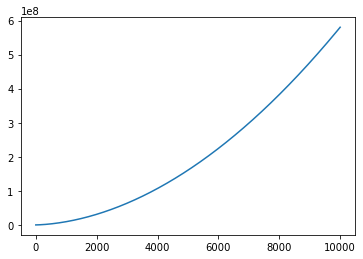

In [477]:
plt.plot(dist)

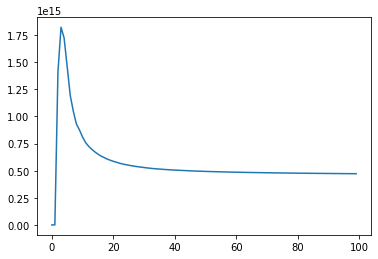

In [478]:
plt.plot(distVI)